In [1]:
from lstchain.io.io import read_dl2_to_pyirf, dl2_params_lstcam_key
import logging
import operator
from lstchain.mc import plot_utils
import os
import numpy as np
from astropy import table
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import QTable
import pandas as pd

from pyirf.io.eventdisplay import read_eventdisplay_fits
from pyirf.binning import (
    create_bins_per_decade,
    add_overflow_bins,
    create_histogram_table,
)
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_HEGRA,
    IRFDOC_PROTON_SPECTRUM
)
from pyirf.cut_optimization import optimize_gh_cut

from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    psf_table,
    background_2d,
)

from pyirf.io import (
    create_aeff2d_hdu,
    create_psf_table_hdu,
    create_energy_dispersion_hdu,
    create_rad_max_hdu,
    create_background_2d_hdu,
)

log = logging.getLogger("pyirf")

/Users/davidsudm/opt/anaconda3/envs/cta-lstchain_sipm.v.0.6.3_pyirf.v.0.4/lib/python3.7/site-packages/ctapipe/tools/stage1.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def get_obstime_real(events):
    """Calculate the effective observation time"""
    deltat = np.diff(events.dragon_time)
    rate=1/np.mean(deltat[(deltat > 0) & (deltat < 0.1)])
    dead_time = np.amin(deltat)
    t_elapsed = events.shape[0]/rate * u.s
    total_dead_time=events.shape[0]*dead_time
    t_eff = t_elapsed/(1+rate*dead_time)
    print("ELAPSED TIME: %.2f s\n" % t_elapsed.to_value(),
          "EFFECTIVE TIME: %.2f s\n" % t_eff.to_value(),
          "DEAD TIME: %0.2E s\n" % dead_time,
          "TOTAL DEAD TIME: %.2f s\n" % total_dead_time, 
          "RATE: %.2f 1/s\n" % rate
    )

    return t_eff


def read_real_dl2_to_pyirf(filename):
    """
    Read DL2 files of real data from lstchain and convert into pyirf internal format
    Parameters
    ----------
    filename: path
    Returns
    -------
    `astropy.table.QTable`, `pyirf.simulations.SimulatedEventsInfo`
    """

    ## mapping
    name_mapping = {
        'alt_tel': 'pointing_alt',
        'az_tel': 'pointing_az',
        'gammaness': 'gh_score',
    }

    unit_mapping = {
        'reco_energy': u.TeV,
        'pointing_alt': u.rad,
        'pointing_az': u.rad,
        'reco_alt': u.rad,
        'reco_az': u.rad,
    }

    events = pd.read_hdf(filename, key=dl2_params_lstcam_key).rename(columns=name_mapping)
    
    obstime_real = get_obstime_real(events) #Calculate effective observation time
    
    events = events
    events = table.QTable.from_pandas(events)

    for k, v in unit_mapping.items():
        events[k] *= v

    return events, obstime_real

In [3]:
#Observation time for sensitivity
T_OBS = 50 * u.hour
# scaling between on and off region.
# Make off region 5 times larger than on region for better
# background statistics
ALPHA = 1/5

# Radius to use for calculating bg rate
MAX_BG_RADIUS = 1.0 * u.deg

# gamma efficiency used for first calculation of the binned theta cuts
# initial theta cuts are calculated using a fixed g/h cut corresponding to this efficiency
# then g/h cuts are optimized after applying these initial theta cuts. 
INITIAL_GH_CUT_EFFICENCY = 0.5

#gamma efficiency used for gh cuts calculation
MAX_GH_CUT_EFFICIENCY = 1.0 # Mabel put 0.8
GH_CUT_EFFICIENCY_STEP = 0.01

#Number of energy bins
N_EBINS = 20
#Energy range
EMIN=0.05  #TeV
EMAX=50  #TeV

#Fixed cuts
INTENSITY_CUT = 100
LEAKAGE2_CUT = 0.2


In [4]:
# --dl2_gamma_test /Users/davidsudm/Desktop/dl2_files/data/dl2_gamma_on_merge.h5
# --dl2_proton_test /Users/davidsudm/Desktop/dl2_files/data/dl2_proton_merge_test.h5
# --output_dir /Users/davidsudm/Desktop/dl2_files/david
# --intensity_cut 200 --leakage_cut 0.2

path_to_data = '/Users/davidsudm/Desktop/dl2_files/data/'

file_gammas = os.path.join(path_to_data, 'dl2_gamma_on_merge.h5')
file_protons = os.path.join(path_to_data, 'dl2_proton_merge_test.h5')

#file_on = "/home/queenmab/DATA/LST/ON/Run2007_on.h5"
#file_off = "/home/queenmab/DATA/LST/OFF.h5"

In [5]:
events_g, simu_info_g = read_dl2_to_pyirf(file_gammas)
events_p, simu_info_p = read_dl2_to_pyirf(file_protons)

Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped
Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped


In [6]:
for events in (events_g, events_p):
        events['good_events'] = (events['intensity']>=INTENSITY_CUT) & \
        (events['leakage_intensity_width_2']<=LEAKAGE2_CUT)

In [7]:
particles = {
         "gamma": {
                "events": events_g[events_g['good_events']],
                "simulation_info": simu_info_g,
                "target_spectrum": CRAB_HEGRA
            },
        "proton": {
                "events": events_p[events_p['good_events']],
                "simulation_info": simu_info_p,
                "target_spectrum": IRFDOC_PROTON_SPECTRUM
            }
        }

In [8]:
# Manage MC gammas:
#Get simulated spectrum
particles["gamma"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["gamma"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum (Crab Hegra)
particles["gamma"]["events"]["weight"] = calculate_event_weights(
        particles["gamma"]["events"]["true_energy"], 
        particles["gamma"]["target_spectrum"], 
        particles["gamma"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["gamma"]["events"][k] = calculate_source_fov_offset(particles["gamma"]["events"], prefix=prefix) 
particles["gamma"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["gamma"]["events"])
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["gamma"]["events"]["theta"] = calculate_theta(
        particles["gamma"]["events"],
        assumed_source_az=particles["gamma"]["events"]["true_az"],
        assumed_source_alt=particles["gamma"]["events"]["true_alt"],
        )

In [9]:
# Manage MC protons:
#Get simulated spectrum
particles["proton"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["proton"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum:
particles["proton"]["events"]["weight"] = calculate_event_weights(
        particles["proton"]["events"]["true_energy"], 
        particles["proton"]["target_spectrum"], 
        particles["proton"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["proton"]["events"][k] = calculate_source_fov_offset(particles["proton"]["events"], prefix=prefix)        
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["proton"]["events"]["theta"] = calculate_theta(
        particles["proton"]["events"],
        assumed_source_az=particles["proton"]["events"]["pointing_az"],
        assumed_source_alt=particles["proton"]["events"]["pointing_alt"],
        )

In [10]:
#Get events
gammas = particles["gamma"]["events"]
protons = particles["proton"]["events"]

In [11]:
#Sensitivity energy bins
sensitivity_bins = np.logspace(np.log10(EMIN),
    np.log10(EMAX), N_EBINS + 1) * u.TeV

In [12]:
signal=gammas
background=protons

In [13]:
#Calculate an initial GH cut for calculating initial theta cuts, based on INITIAL_GH_CUT_EFFICIENCY
INITIAL_GH_CUT = np.quantile(signal['gh_score'], (1 - INITIAL_GH_CUT_EFFICENCY))
INITIAL_GH_CUT

0.373547619047619

In [14]:
# theta cut is 68 percent containmente of the gammas
# for now with a fixed global, unoptimized score cut
mask_theta_cuts = signal["gh_score"] >= INITIAL_GH_CUT
theta_cuts = calculate_percentile_cut(
        signal["theta"][mask_theta_cuts],
        signal["reco_energy"][mask_theta_cuts],
        bins=sensitivity_bins,
        fill_value=np.nan * u.deg,
        percentile=68,
)

In [15]:
# evaluate the initial theta cut
signal["selected_theta"] = evaluate_binned_cut(
    signal["theta"], signal["reco_energy"], theta_cuts, operator.le
    )

In [16]:
log.info("Optimizing G/H separation cut for best sensitivity")
gh_cut_efficiencies = np.arange(
        GH_CUT_EFFICIENCY_STEP,
        MAX_GH_CUT_EFFICIENCY + GH_CUT_EFFICIENCY_STEP / 2,
        GH_CUT_EFFICIENCY_STEP
)
sensitivity_step_2, gh_cuts = optimize_gh_cut(
    signal[signal["selected_theta"]],
    background,
    reco_energy_bins=sensitivity_bins,
    gh_cut_efficiencies=gh_cut_efficiencies,
    theta_cuts=theta_cuts,
    op=operator.ge,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
)

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


In [17]:
#Evaluate gh cut
for tab in (gammas, protons):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

In [18]:
#Evaluate gh cut:
for tab in (gammas, protons):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

theta_cuts_opt = calculate_percentile_cut(
    gammas[gammas["selected_gh"]]["theta"],
    gammas[gammas["selected_gh"]]["reco_energy"],
    sensitivity_bins,
    percentile=68,
    fill_value=0.32 * u.deg,
    )

In [19]:
gammas["selected_theta"] = evaluate_binned_cut(
        gammas["theta"], gammas["reco_energy"], theta_cuts_opt, operator.le
    )
gammas["selected"] = gammas["selected_theta"] & gammas["selected_gh"]

protons["selected"] =  protons["selected_gh"]

In [20]:
gamma_hist = create_histogram_table(
    gammas[gammas["selected"]], bins=sensitivity_bins
    )    
proton_hist = estimate_background(
    protons[protons["selected"]],
    reco_energy_bins=sensitivity_bins,
    theta_cuts=theta_cuts_opt,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
    )

In [21]:
sensitivity_mc = calculate_sensitivity(
    gamma_hist, proton_hist, alpha=ALPHA
)
sensitivity_mc

Could not calculate relative significance for n_signal=0.0, n_off=0.0, returning nan f(a) and f(b) must have different signs


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,159.74247434863332,367.1886811067119,20.554420242753004,21764.388703206707,5.00000000000058,0.28886523390349605
0.0706268772311377,0.09976311574844397,0.08519499648979084,297.7419280893258,533.9805257332623,48.771422428260976,46491.370025470256,5.0000000000010685,0.0978127227625906
0.09976311574844397,0.14091914656322266,0.12034113115583331,347.72500492380607,519.9648647200569,51.86162496811322,44056.664636752874,5.000000000001194,0.042524765185741234
0.14091914656322266,0.1990535852767486,0.16998636591998562,363.5317673287138,447.7294777985911,44.714025320775804,32546.819240453955,4.99999999999942,0.024006588346345756
0.1990535852767486,0.2811706625951745,0.24011212393596154,244.03251713447872,243.3518658626035,15.095580445027675,9403.917891233823,4.9999999999999885,0.019997747859909754
0.2811706625951745,0.39716411736214063,0.3391673899786576,263.5173891499171,212.20539113632907,12.862688306684396,7099.63301486776,4.999999999999528,0.01916211381253033
0.39716411736214063,0.5610092271509817,0.47908667225656115,65.4514990312147,42.224680468394126,0.4661477761669373,221.72469855975416,4.999999999999993,0.017892700664629495
0.5610092271509817,0.7924465962305566,0.6767279116907692,29.443326760147695,15.255238005262616,0.0458006067856371,15.14083139801665,4.999999999999998,0.01685365012029061


In [22]:
# scale relative sensitivity by Crab flux to get the flux sensitivity
spectrum = particles['gamma']['target_spectrum']

In [23]:
sensitivity_mc["flux_sensitivity"] = sensitivity_mc["relative_sensitivity"] * spectrum(sensitivity_mc["reco_energy_center"])

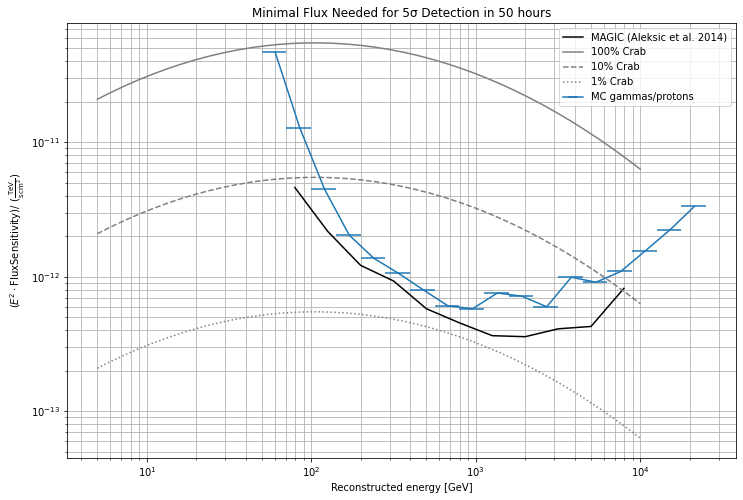

In [24]:
plt.figure(figsize=(12,8))
ax=plt.axes()
unit = u.Unit('TeV cm-2 s-1')

e = sensitivity_mc['reco_energy_center']

s_mc = (e**2 * sensitivity_mc['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_mc.to_value(unit),
    xerr=(sensitivity_mc['reco_energy_high'] - sensitivity_mc['reco_energy_low']).to_value(u.GeV) / 2,
    label='MC gammas/protons',
    )

#Plot magic sensitivity
s = np.loadtxt('/Users/davidsudm/software/cta-lstchain_sipm.v.0.6.3/lstchain/spectra/data/magic_sensitivity.txt', skiprows = 1)
ax.loglog(s[:,0], s[:,3] * np.power(s[:,0]/ 1e3, 2),
              color = 'black', label = 'MAGIC (Aleksic et al. 2014)')

#Plot Crab SED
plot_utils.plot_Crab_SED(ax, 100, 5*u.GeV, 1e4*u.GeV, label="100% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 10, 5*u.GeV, 1e4*u.GeV, linestyle='--', label="10% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 1, 5*u.GeV, 1e4*u.GeV, linestyle=':', label="1% Crab") #Energy in GeV


# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [GeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")
plt.legend()
plt.show()

In [25]:
proton_hist

reco_energy_low,reco_energy_high,reco_energy_center,n,n_weighted
TeV,TeV,TeV,,
float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,20.554420242753004,21764.388703206707
0.0706268772311377,0.09976311574844397,0.08519499648979084,48.771422428260976,46491.370025470256
0.09976311574844397,0.14091914656322266,0.12034113115583331,51.86162496811322,44056.664636752874
0.14091914656322266,0.1990535852767486,0.16998636591998562,44.714025320775804,32546.819240453955
0.1990535852767486,0.2811706625951745,0.24011212393596154,15.095580445027675,9403.917891233823
0.2811706625951745,0.39716411736214063,0.3391673899786576,12.862688306684396,7099.63301486776
0.39716411736214063,0.5610092271509817,0.47908667225656115,0.4661477761669373,221.72469855975416
0.5610092271509817,0.7924465962305566,0.6767279116907692,0.0458006067856371,15.14083139801665


In [26]:
gamma_hist

reco_energy_low,reco_energy_high,reco_energy_center,n,n_weighted
TeV,TeV,TeV,,
float64,float64,float64,int64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,553,1271.1418267432698
0.0706268772311377,0.09976311574844397,0.08519499648979084,3044,5459.213389134774
0.09976311574844397,0.14091914656322266,0.12034113115583331,8177,12227.34240739332
0.14091914656322266,0.1990535852767486,0.16998636591998562,15143,18650.275138605597
0.1990535852767486,0.2811706625951745,0.24011212393596154,12203,12168.963603669603
0.2811706625951745,0.39716411736214063,0.3391673899786576,13752,11074.216196209287
0.39716411736214063,0.5610092271509817,0.47908667225656115,3658,2359.883019328903
0.5610092271509817,0.7924465962305566,0.6767279116907692,1747,905.1592916893642


In [27]:
gammas

intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,obs_id,event_id,calibration_id,true_energy,log_mc_energy,true_alt,true_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,pointing_az,pointing_alt,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gh_score,good_events,weight,true_source_fov_offset,reco_source_fov_offset,source_fov_offset,theta,selected_theta,selected_gh,selected
,,,,,,,,,,,,,,,,,,,,,,,,,TeV,,rad,rad,,,,,rad,rad,,,,,,,,,,,,,,,,,TeV,,,,,rad,rad,,,,,deg,deg,deg,deg,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,int32,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,float64,float64,float64,float64,float64,bool,bool,bool
181.7610583305359,2.2595008427818803,0.48419696110099447,0.3142039062889991,0.5772094869860543,0.5756138959744419,0.16371981970844957,0.0627861280637932,0.4972032335408144,0.22397107944636782,2.066049402905137,8.282562803608432,12.257659937471216,0.0,0.0,0.0,0.0,16,0.3009466114782289,0.24804326396838589,0.19251380147089187,1,101,1400,-1,0.00911790318787098,-2.0401050233642195,1.2217304706573486,3.1415927410125732,16.509984970092773,-1.677108883857727,14337.9287109375,0,3.1415927410125732,1.2217304706573486,520.0,100.9217244661682,0.3834974175735231,1,-70.93,-52.07,43.0,0,-0.48419574,-0.31420392,0.57720846,0.57561505,-1.0,1.223919e-06,0.0,-0.8867951808482857,0.12977911825546912,-0.4962937731406993,-0.25785214511479526,-0.012096812039704807,0.05635176117420382,1.2212928783230836,3.147470044964728,101,0.44666666666666666,True,7.538248539220689,3.3059086758748746e-07,0.11793829602743823,3.3059086758748746e-07,0.11793836541387748,True,False,False
356.07299613952637,2.551539038902329,-0.02586723800568779,0.14172942364642346,0.14407061993755105,1.7513207967245383,0.16272895195141515,0.058985647999594736,-1.2464912093523157,-0.42107332664162084,2.0999413066480974,-6.356303443295602,14.181169739979534,0.0,0.0,0.0,0.0,22,0.30334896201163114,0.39565625265504345,0.1640773869328268,2,101,2503,-1,0.11014436930418015,-0.9580376995357099,1.2217304706573486,3.1415927410125732,-69.81986236572266,10.1871976852417,34340.87109375,0,3.1415927410125732,1.2217304706573486,256.6666564941406,62.26709429437911,0.3624778952500454,1,-70.93,-52.07,43.0,0,0.025868462,-0.14172943,0.14407083,-1.3902636,1.0,1.223919e-06,0.0,-0.9807020628590565,0.10454371699514421,0.11764751040927741,-0.3193120369550787,0.09178027240358963,-0.17758261330865524,1.2249525768882545,3.122882694626374,101,0.4268333333333333,True,1.6083801754665754,3.3059086758748746e-07,0.409046231519318,3.3059086758748746e-07,0.40904607973216667,False,False,False
565.7499437332153,2.7526245194339154,0.5597771954316807,-0.26344471486240983,0.6186708545860994,-0.43987205597343004,0.2714716304384843,0.06164658666179329,-0.4561504543999167,0.16363196695298574,2.161558410073179,5.759279027771537,13.839363644138922,0.0,0.0,0.0,0.0,31,0.22655537524249394,0.3930673084115265,0.09977506718777403,1,101,2800,-1,0.2205287665128708,-0.6565347516703172,1.2217304706573486,3.1415927410125732,131.0974578857422,-130.79698181152344,27687.205078125,0,3.1415927410125732,1.2217304706573486,265.65216064453125,216.82488689328582,0.22708297939722455,1,-70.93,-52.07,43.0,0,-0.55977595,0.26344472,0.61866975,-0.4398729,-1.0,1.223919e-06,0.0,-0

In [28]:
protons

intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,obs_id,event_id,calibration_id,true_energy,log_mc_energy,true_alt,true_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,pointing_az,pointing_alt,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gh_score,good_events,weight,true_source_fov_offset,reco_source_fov_offset,theta,selected_gh,selected
,,,,,,,,,,,,,,,,,,,,,,,,,TeV,,rad,rad,,,,,rad,rad,,,,,,,,,,,,,,,,,TeV,,,,,rad,rad,,,,,deg,deg,deg,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,int32,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,float64,float64,float64,float64,bool,bool
133.12902069091797,2.1242727373087136,-0.1875842618687348,0.5552175105355567,0.5860497754509757,1.8966128664839461,0.1346655056342522,0.05126106422570458,0.36201964009202864,0.0707399673471511,1.8667911395989196,3.6410948258530422,11.813612854665807,0.0,0.0,0.0,0.0,12,0.3609133322945253,0.4472607704742266,0.16848225967903813,1,1000,21709,-1,0.1733301728963852,-0.7611258297743264,1.1067874431610107,3.1422173976898193,625.9674072265625,24.89336585998535,19538.001953125,101,3.1415927410125732,1.2217304706573486,443.3333435058594,701.1343353894323,0.38065474884806966,1,-70.93,-52.07,43.0,0,-3.030817,-0.54733795,3.0798426,0.17866522,-1.0,-3.2184012,0.007879584,-1.352125055541285,0.04445032538715311,-0.1792555911813582,-0.047744196957384015,-0.36683985305009303,0.5074733135781727,1.2081937359165749,3.1927033755383905,101,0.15766666666666668,True,1411.0662911959037,6.585764948050495,1.281312954900942,1.2813129552474156,False,False
118.76984453201294,2.0747061879871227,0.3188190411284175,0.5688461384830538,0.6520977766049545,1.059953162812509,0.10080719698433968,0.05661966877149987,-0.3968388282526971,0.6980975431072863,2.6514405291049368,-3.30491212561677,13.461572922088118,0.0,0.0,0.0,0.0,25,0.6271877342146429,0.5114944343009856,0.3308165556552417,3,1000,45603,-1,0.3489316701889038,-0.457259610763769,1.2069308757781982,3.2499969005584717,223.1637725830078,-374.0477294921875,19564.3828125,101,3.1415927410125732,1.2217304706573486,214.0,436.0743121729029,0.5616629612297988,1,-70.93,-52.07,43.0,0,-0.67823505,0.5096314,0.8483672,-0.6444017,-1.0,-0.35941604,1.0784775,-1.4667848942709218,0.0341361946071382,-0.11648497845341886,0.008496289093546303,0.20233406267499865,0.5773424275766,1.2283613130263895,3.2030325057842037,101,0.16152380952380951,True,914.4297804471809,2.3261332732582227,1.2518430601799355,1.2518430606389814,False,False
396.0844430923462,2.597787785065666,-0.021528051560959393,-0.8156950428084994,0.8159790805323203,-1.5971824809913402,0.12416933558974627,0.08760652864625196,0.20190633719350712,-0.4810850701402144,2.5781182662660074,7.805712147751403,13.118812213704299,0.0,0.0,0.0,0.0,20,0.2440708929668346,0.4646889804932137,0.18547368587263763,1,1000,86705,-1,1.5762910842895508,0.19763641913559823,1.2183231115341187,3.170413017272949,-92.973876953125,-616.0344848632812,27888.158203125,101,3.1415927410125732,1.2217304706573486,177.3333282470703,564.3951390905071,0.7055407700311991,1,-70.93,-52.07,43.0,0,-0.07010472,1.094244,1.0964874,-1.506817,-1.0,-0.091632776,0.27854896,-1.0090139490185266,0.09794585258689019,0.1479627507176723,0.04661127397190367,0.1264346991567129,-0.7690837688365957,1.22

In [30]:
output_data_file = '/Users/davidsudm/Desktop/dl2_files/official/data/sensitivity.hdf5'
sensitivity_mc.write(output_data_file, path='sensitivity/standard', serialize_meta=True)
gammas.write(output_data_file, path='events/gamma_on', serialize_meta=True, append=True)
protons.write(output_data_file, path='events/proton', serialize_meta=True, append=True)

proton_hist.write(output_data_file, path='histogram/proton', serialize_meta=True, append=True)
gamma_hist.write(output_data_file, path='histogram/gamma_on', serialize_meta=True, append=True)

print("sensitivity.hdf5 saved as {}".format(output_data_file))

sensitivity.hdf5 saved as /Users/davidsudm/Desktop/dl2_files/official/data/sensitivity.hdf5
